In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh

from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *
from spyrit.restructured.Updated_Had_Dcan import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
alpha = 10     # Image intensity (in photons)
bs = 10 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size
# Cov /= img_size*img_size # THIS NEEDS TO BE NORMALIAZED FOR CONSISTENCY!

Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Pmat = np.dot(Perm,H);
Pmat = Pmat[:M,:];

In [6]:
x = inputs.view(b*c,w*h)

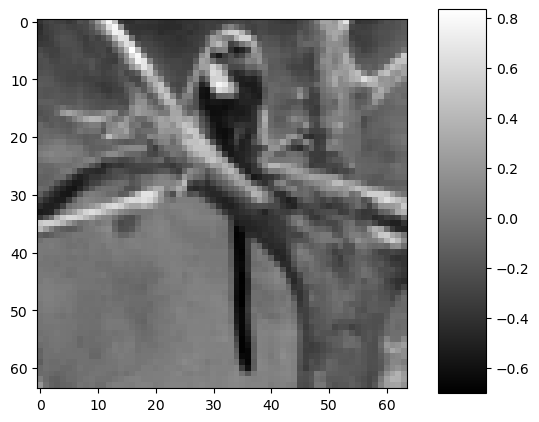

In [7]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [8]:
FO = Forward_operator(Pmat)
FO_split = Split_Forward_operator(Pmat)

Input Matrix shape: (100, 32)
x input shape torch.Size([4, 32])
Forward propagation layer: Linear(in_features=32, out_features=100, bias=False)
weight size: torch.Size([100, 32])
Forward propagation layer weights:

Backpropagaton layer: Linear(in_features=100, out_features=32, bias=False)
y shape: torch.Size([4, 100])


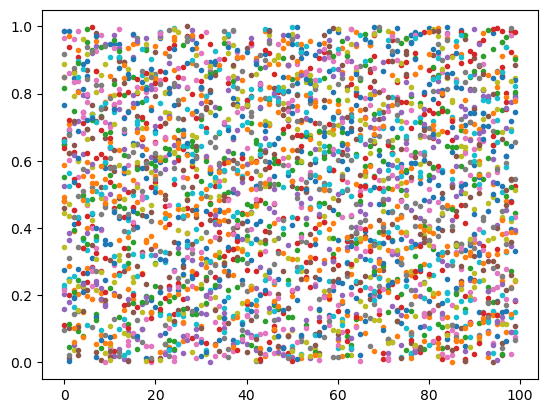

In [9]:
# example for package docs
# ==========================
Input_Matrix = np.array(np.random.random([100,32]))



x_input= torch.tensor(np.random.random([4,Input_Matrix.shape[1]]), dtype=torch.float) # faut absolument mettre le float et pas float 64
print('Input Matrix shape:', Input_Matrix.shape)
print('x input shape',x_input.shape)
Forwad_OP = Forward_operator(Input_Matrix)
print('Forward propagation layer:',Forwad_OP.Hsub)
import matplotlib.pyplot as plt
print('weight size:', Forwad_OP.Hsub.weight.size())
print('Forward propagation layer weights:\n')
plt.plot(Forwad_OP.Hsub.weight, '.')
# plt.figure()
# plt.hist(Forwad_OP.Hsub.weight)
print('Backpropagaton layer:', Forwad_OP.Hsub_adjoint)
y = Forwad_OP(x_input)
print('y shape:', y.shape)

In [10]:
Split_Forwad_OP =  Split_Forward_operator(Input_Matrix)
print('Split Forward propagation layer:', Split_Forwad_OP.Hpos_neg)

Split Forward propagation layer: Linear(in_features=32, out_features=200, bias=False)


In [11]:
print('Hsub shape (M ,N):', Input_Matrix.shape)
print(f"N*N = {32*32}")
print(Perm.shape)
SFO_FT_Had = Split_Forward_operator_ft_had(Input_Matrix, Perm)
print(SFO_FT_Had)

Hsub shape (M ,N): (100, 32)
N*N = 1024
(4096, 4096)


TypeError: __init__() missing 2 required positional arguments: 'h' and 'w'

# Acquisition
## Instancier

In [ ]:
A = Acquisition(FO);
print(FO)
print(A)

## Test methode forward

In [ ]:
y = 2*A(x)-FO.Forward_op(torch.ones_like(x))

In [ ]:
x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Bruit_Poisson_approx_Gauss 
## Instancier

In [ ]:
A_b = Acquisition_Poisson_approx_Gauss(alpha, FO_split)
print(A_b)

## Test methode forward

In [ ]:
m = A_b(x)

In [ ]:
even_index = range(0,2*M,2);
odd_index = range(1,2*M,2);
mplus = m[:, even_index];
mminus = m[:, odd_index];
y = 2*(mplus-mminus)/N0 - FO_split.Forward_op(torch.ones_like(x))

x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

Montrer images avec plusieurs N0

# Bruit_Poisson_Pytorch 
## Instancier

In [ ]:
A_b = Bruit_Poisson_Pytorch(N0, FO_split)

## Test methode forward

In [ ]:
m = A_b(x)

In [ ]:
even_index = range(0,2*M,2);
odd_index = range(1,2*M,2);
mplus = m[:, even_index];
mminus = m[:, odd_index];
y = 2*(mplus-mminus)/N0 - FO(torch.ones_like(x))

x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

TO DO :
* Test that the Gaussian approx is the same as the pytorch one
* Check which one is faster
* Implement Gaussian additive noise
* Implement Mixed Poisson-Gaussian Noise
* Check Mean and Var of noisy measurements (is it equal to $N0*A(x)$
    

http://wiki.stat.ucla.edu/socr/index.php/AP_Statistics_Curriculum_2007_Limits_Norm2Poisson